## Analyze floorplan's structure with Jupyter Notebook

Jupyter Notebook is a nice tool for data analysis since it can bind analysis, code, and result together with interactive process. However, floor plan analysis has been done in a seprate software such as depthmap and it could not utilize the power of interactive process. In this notebook, I'd like to demonstrate how we can analyze a floor plan's network structure with Jupyter Notebook.

We are going to use GeoPandas to manage spatial data and NetworkX to calculate network properties. 

In [16]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

import warnings
warnings.filterwarnings('ignore')

### Dataset

We will import floorplan data from esri's FileGDB. You can use any type of spatial data supported by OGR driver such as shp, dxf, and dwg. In this notebook, the key data set is room polygons. In our dataset, we created room boundary polygons for all rooms including circulation spaces. Other lines are just graphics irrelevant from actual analysis.

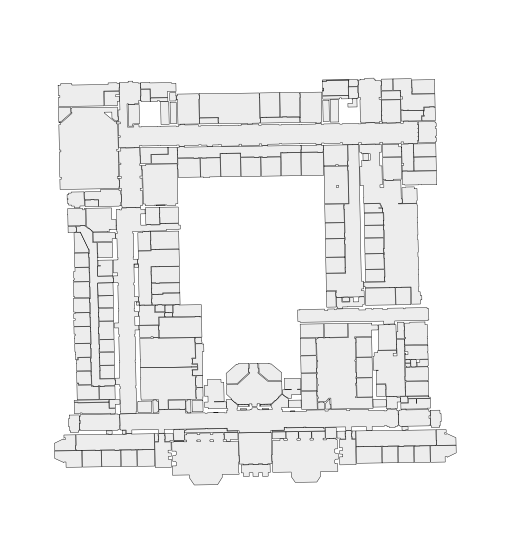

In [4]:
# read room polygons in esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  # room polygon is the second layer in our gdb

# let's look at them
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, color='#DDDDDD')
plt.show()

### Original floorplan

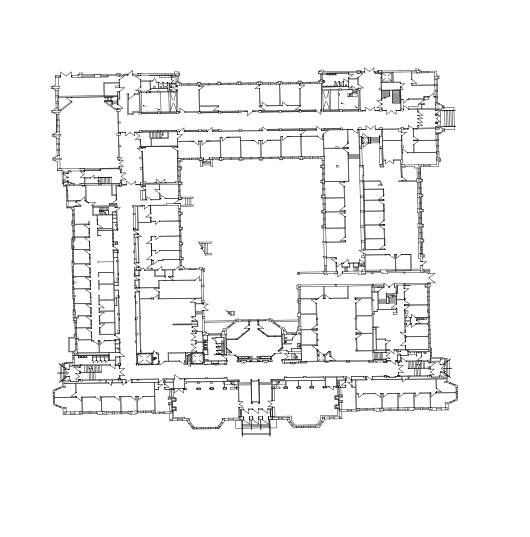

In [13]:
graphics = gpd.read_file(gdb_path, layer=3)  # third layer in the gdb

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
graphics.plot(ax=ax, linewidth=0.3, color='k')
plt.show()

### Let's create nodes at the centroid

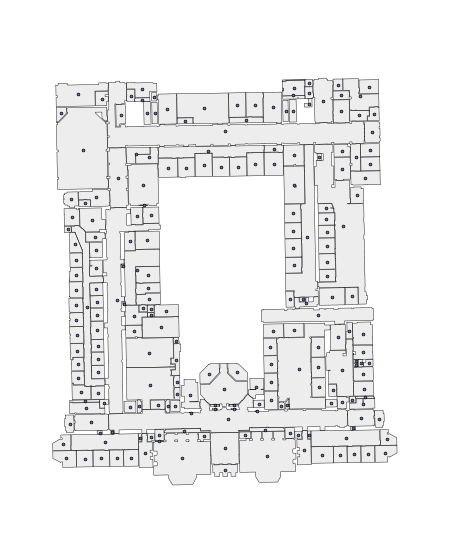

In [15]:
nodes = rooms.geometry.centroid

# then plot the nodes over room polygons
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, color='#DDDDDD')
nodes.plot(ax=ax, markersize=2, color='#6677AA')
ax.set_aspect('equal')
plt.show()

### Create edge
Room polygons touch each other if the rooms are connected directly or through doors. If there is a wall between two rooms, there should be a gap between the room polygons. We will give some threshold judging 'touch'.

In [17]:
threshold = 0.02

# dictionary for edge geometry
lines = {'geometry':[], 'from':[], 'to':[]}

for index1, room1 in rooms.iterrows():
    for index2, room2 in rooms.iterrows():
        if room1.geometry.buffer(threshold).intersects(room2.geometry.buffer(threshold)) \
            and index1 > index2:
            lines["from"].append(index1)
            lines["to"].append(index2)
            lines["geometry"].append(LineString([room1.geometry.centroid, room2.geometry.centroid]))

# geodataframe for edges
edges = gpd.GeoDataFrame(lines)

### Let's see how rooms are connected

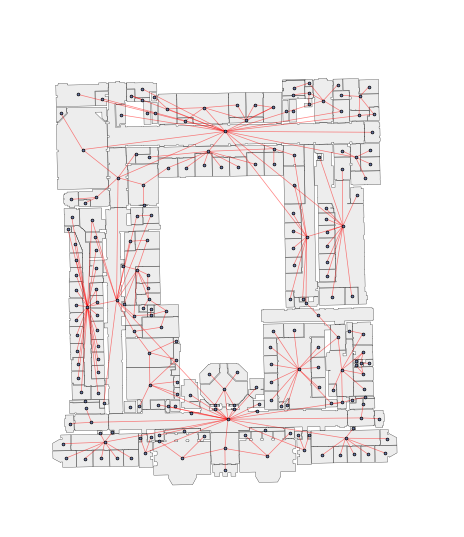

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.2, color='#DDDDDD')
edges.plot(ax=ax, linewidth=0.5, color='r', alpha=0.5)
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#6677AA')
ax.set_aspect('equal')
plt.show()

## Let's calculate some network measures.

In [80]:
room_network = nx.Graph()
for i, edge in edges.iterrows():
    room_network.add_edge(edge["from"], edge["to"])

# calculate closeness and add the values to rooms
closeness = nx.closeness_centrality(room_network)
rooms['closeness'] = pd.Series(closeness)

# calculate betweenness and add the values to rooms
betweenness = nx.betweenness_centrality(room_network)
rooms['betweenness'] = pd.Series(betweenness)

### color rooms by closeness

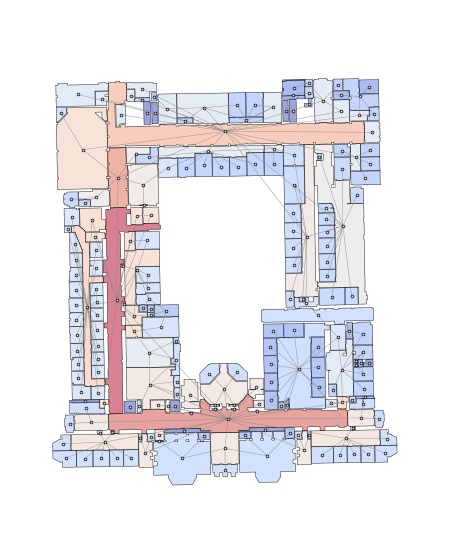

In [24]:
# color rooms by closeness
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, column='closeness', cmap='coolwarm')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#DDDDDD')
ax.set_aspect('equal')
plt.show()

#### Distribution of closeness centrality

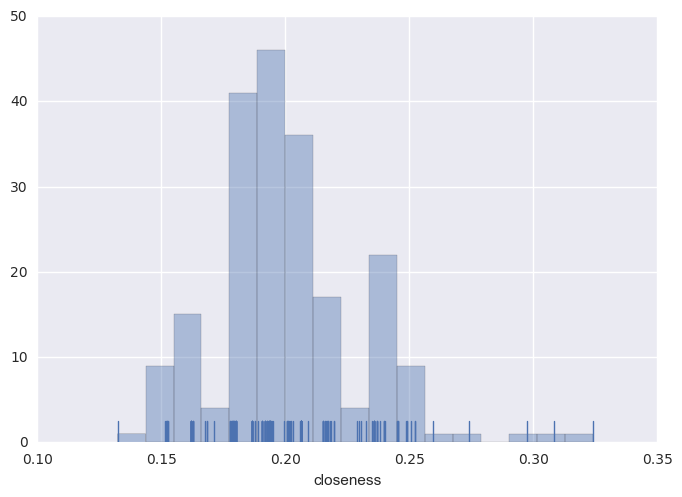

In [87]:
import seaborn as sns
sns.set(color_codes=True)
clo = rooms["closeness"][rooms["closeness"].notnull()]
sns.distplot(clo, kde=False, rug=True);
sns.plt.show()

### color rooms by closeness

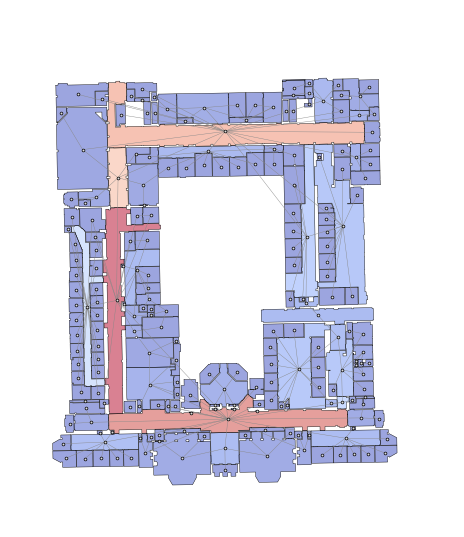

In [27]:
# color rooms by betweenness
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, column='betweenness', cmap='coolwarm')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#DDDDDD')
ax.set_aspect('equal')
plt.show()

#### Distribution of betweenness centrality

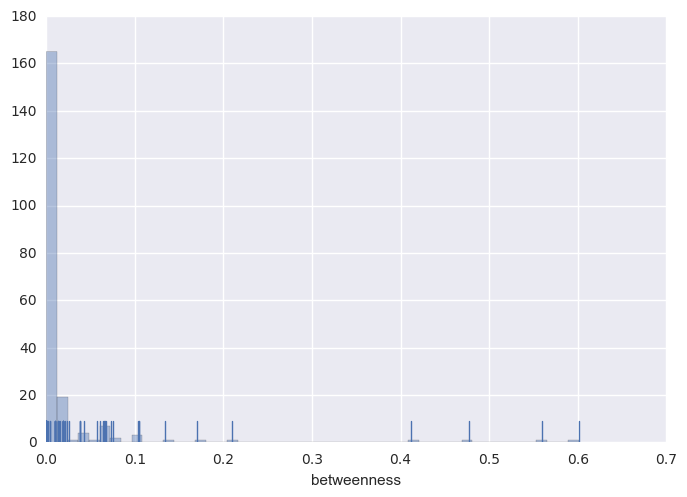

In [89]:
sns.set(color_codes=True)
btw = rooms["betweenness"][rooms["betweenness"].notnull()]
sns.distplot(btw, kde=False, rug=True);
sns.plt.show()

## Identify 'regions'(well-grouped rooms) in the floor

In [67]:
# find community structure in room network using Girvan-Newman algorithm
comp = nx.girvan_newman(room_network)
k = 6  ## number of communities

community = dict()
import itertools
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
comm_structure = None
for communities in limited:
    comm_structure = (list(c for c in communities))

for cid, comm in enumerate(comm_structure):
    for node in comm:
        community[node] = cid


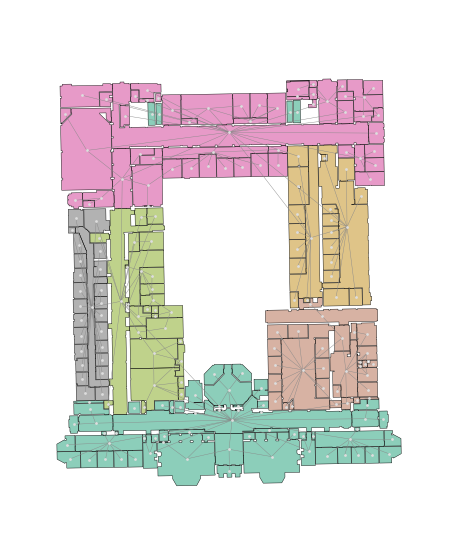

In [90]:
rooms['community'] = pd.Series(community)

# color rooms by community
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, column='community', cmap='Dark2')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=2, color='#DDDDDD')
ax.set_aspect('equal')
plt.show()